## Data preparation: extraction set of all cuisines##
We start the second task in the capstone project with standard step of Data Science: data preparation. Particularly we are going to load JSON file as Apache Spark DataFrame (https://spark.apache.org/docs/latest/sql-programming-guide.html) and extract set of all cuisines that are presented in 'categories' attribute.

In [2]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf, col, lit
from pyspark.sql.types import BooleanType

basePath = 'dataminingcapstone-001'
workingDir = os.path.join(os.curdir, basePath)

sqlContext = SQLContext(sc)

targetDir = os.path.join(workingDir, 'yelp_dataset_challenge_academic_dataset')

businessJSON = os.path.join(targetDir, 'yelp_academic_dataset_business.json')
businessDF = sqlContext.read.json(businessJSON)

reviewsJSON = os.path.join(targetDir, 'yelp_academic_dataset_review.json')
reviewsDF = sqlContext.read.json(reviewsJSON)

contains = udf(lambda xs, val: val in xs, BooleanType())
restaurantsDF = businessDF[contains(businessDF.categories, lit("Restaurants"))]

allSubcategories = set(restaurantsDF.select("categories").flatMap(lambda x: x.categories).distinct().collect())
allSubcategories.remove(u'Restaurants')

Now we collected all distinct values presented in categories of restaurant businesses. Let's exam what the set contains.

In [5]:
print allSubcategories

set([u'Salvadoran', u'Street Vendors', u'Dry Cleaning & Laundry', u'Tapas/Small Plates', u'Fondue', u'Buffets', u'Cheese Shops', u'Arts & Entertainment', u'Arabian', u'Sandwiches', u'Shaved Ice', u'Creperies', u'Poutineries', u'Sushi Bars', u'Belgian', u'Tea Rooms', u'Drugstores', u'Dim Sum', u'Fitness & Instruction', u'French', u'Dive Bars', u'Slovakian', u'Adult Entertainment', u'Juice Bars & Smoothies', u'Karaoke', u'Bistros', u'Grocery', u'Hookah Bars', u'Wine Bars', u'Salad', u'Gelato', u'Gluten-Free', u'Patisserie/Cake Shop', u'Food Delivery Services', u'Nightlife', u'Sporting Goods', u'Bowling', u'Cocktail Bars', u'Specialty Schools', u'Persian/Iranian', u'Italian', u'Steakhouses', u'Fashion', u'Mediterranean', u'Moroccan', u'Active Life', u'Public Services & Government', u'German', u'Delis', u'Bed & Breakfast', u'Hotels & Travel', u'Cantonese', u'Falafel', u'Polish', u'Education', u'Hospitals', u'Tex-Mex', u'Event Planning & Services', u'Internet Cafes', u'Personal Chefs', u'Ch

We can notice that categories contain not only cuisines, but also not related to restaurants categories, for example, there are categories 'Dry Cleaning & Laundry' or 'Art Galleries'. We will filter out these categories using a guess that real cuisines should have many businesses associated to this category.

In [6]:
countBySubcategories = restaurantsDF.select("categories").flatMap(lambda x: x.categories).countByValue()
countBySubcategories.pop(u'Restaurants', None)

14303

We can see that the hypothesis is true, for instance, the cuisine u'Mexican' is presented in 1749 business units while Kids Activities only in one. In order to determinate the threshold we're going to visualize the distribution using a bar chart.

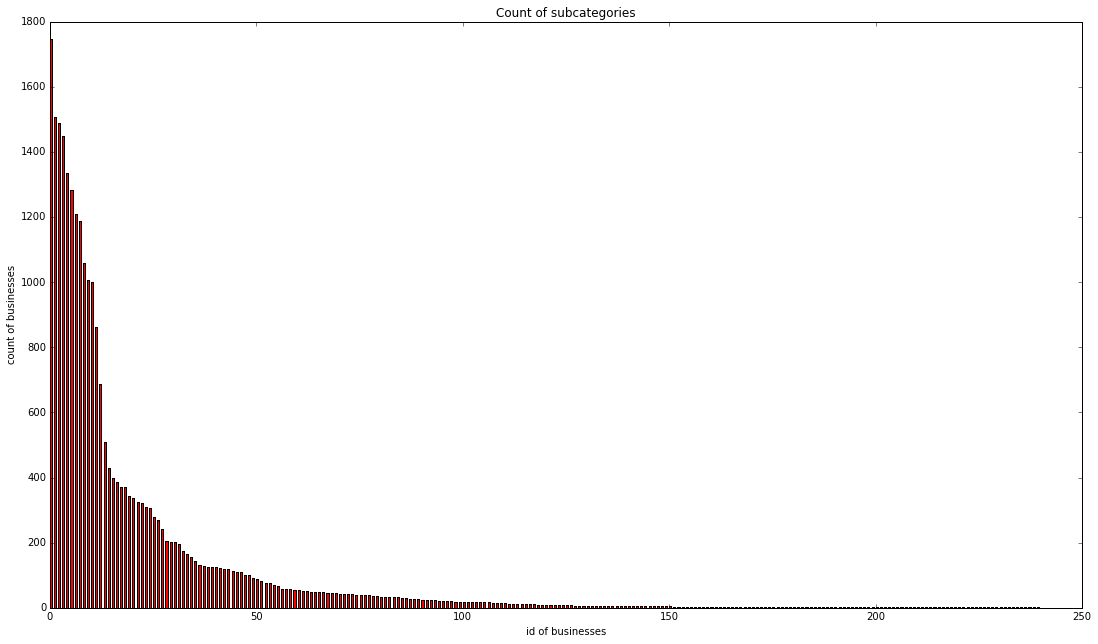

In [7]:
%matplotlib inline

import operator
import numpy as np
import matplotlib.pyplot as plt

sortedSubcategories = sorted(countBySubcategories.items(), key=operator.itemgetter(1), reverse=True)

counts = [c for (cat, c) in sortedSubcategories]
categories = [cat for (cat, c) in sortedSubcategories]

length = len(counts)
width = 0.5

fig, ax = plt.subplots()

ind = np.arange(length)
bar = ax.bar(ind, counts, width, color='r')

ax.set_title('Count of subcategories')
ax.set_ylabel('count of businesses')
ax.set_xlabel('id of businesses')

fig.set_size_inches(18.5, 10.5)
fig.savefig('all_reviews_bars.png', dpi=200)

plt.show()

We can filter out unnecessary categories selecting sequence of categories with of 98% of all area.

In [8]:
target = 0.98
area = float(sum(counts))

cur_sum = float(counts[0])
threshhold = None

i = 0
while cur_sum / area < target:
    cur_sum += float(counts[i])
    i += 1

print 'select first %d categories' % i

select first 56 categories


In [9]:
cuisines = categories[:56]
print cuisines

[u'Mexican', u'American (Traditional)', u'Fast Food', u'Pizza', u'Sandwiches', u'Nightlife', u'Bars', u'Food', u'American (New)', u'Italian', u'Chinese', u'Burgers', u'Breakfast & Brunch', u'Japanese', u'Delis', u'Sushi Bars', u'Steakhouses', u'Cafes', u'Seafood', u'Sports Bars', u'Buffets', u'Coffee & Tea', u'Barbeque', u'Thai', u'Mediterranean', u'Chicken Wings', u'Asian Fusion', u'Pubs', u'Greek', u'Indian', u'Tex-Mex', u'Bakeries', u'Diners', u'Hot Dogs', u'Vietnamese', u'Salad', u'Vegetarian', u'British', u'Arts & Entertainment', u'Lounges', u'French', u'Event Planning & Services', u'Korean', u'Hawaiian', u'Wine Bars', u'Gluten-Free', u'Specialty Food', u'Ice Cream & Frozen Yogurt', u'Middle Eastern', u'Gastropubs', u'Desserts', u'Latin American', u'Bagels', u'Juice Bars & Smoothies', u'Fish & Chips', u'Vegan']


Now everything is ready to split all restaurant reviews by found cuisines.

In [29]:
def combineReviewsByCategory(category):
    businessesByCategory = businessDF[contains(businessDF.categories, lit(category))]
    selectedReviewsDF = reviewsDF.join(businessesByCategory,\
                                       businessesByCategory.business_id == reviewsDF.business_id)    
    return selectedReviewsDF.select("text").map(lambda x: x.text).reduce(lambda a, b: a + b)

In [30]:
reviewsByCategories = [combineReviewsByCategory(c) for c in cuisines]

In [10]:
def calcReviewsCount(category):
    businessesByCategory = businessDF[contains(businessDF.categories, lit(category))]
    selectedReviewsDF = reviewsDF.join(businessesByCategory,\
                                       businessesByCategory.business_id == reviewsDF.business_id)    
    return selectedReviewsDF.select("text").map(lambda x: 1).reduce(lambda a, b: a + b)

reviewsCountByCategories = [calcReviewsCount(c) for c in cuisines]

Let's analyse how many reviews contains each category and display it as bar chart.

In [11]:
print reviewsCountByCategories

[70406, 84895, 22291, 57500, 48716, 142962, 117859, 129524, 94183, 60976, 38716, 43431, 61348, 39553, 12709, 38259, 45338, 14914, 31734, 18156, 32468, 31437, 17440, 20691, 18603, 6770, 20084, 21186, 9857, 8230, 4552, 18753, 7943, 6555, 12538, 9341, 12933, 5268, 87096, 25347, 17155, 74754, 7540, 7866, 12258, 8707, 14647, 15737, 4854, 5424, 18466, 4632, 3617, 6806, 1778, 7021]


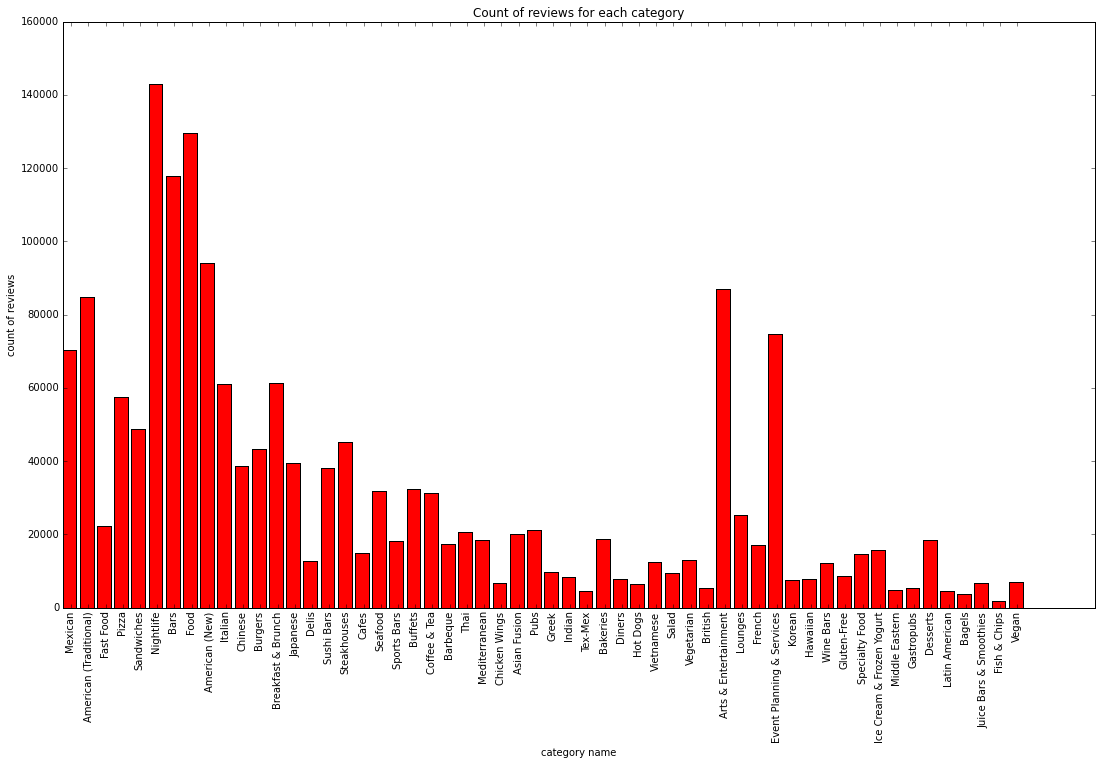

In [17]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

length = len(reviewsCountByCategories)

fig, ax = plt.subplots()

ind = np.arange(length)
bar = ax.bar(ind, reviewsCountByCategories, color='r')

ax.set_title('Count of reviews for each category')
ax.set_ylabel('count of reviews')
ax.set_xlabel('category name')

plt.xticks(ind + 0.5, categories, rotation='vertical')

fig.set_size_inches(18.5, 10.5)
fig.savefig('reviews_count_per_category.png', dpi=200)

plt.show()

## Feature extraction ##
Now we have the combined set of reviews for each category and the next step is to build feature vector based on TF-IFD model. But for first step we will not use IDF.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

def buildTF_IDF(corpus, use_idf=True, max_df=1.0, min_df=1, tokenizer=None):
    vectorizer = TfidfVectorizer(stop_words='english', 
                                 use_idf=use_idf, max_df=max_df, min_df=min_df, tokenizer=tokenizer)
    return vectorizer.fit_transform(corpus)

In [83]:
tf_matrix = buildTF_IDF(reviewsByCategories, use_idf=False)

Then we're going to construct a similariy matrix using cosine similarity metric.  

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_matrix(feature_matrix):
    N = feature_matrix.shape[0]
    res = cosine_similarity(feature_matrix[0:1], feature_matrix)
    for i in range(1, N):
        res = np.vstack((res, cosine_similarity(feature_matrix[i:i+1], feature_matrix)))
        
    return res

In [84]:
tf_cosine_matrix = cosine_matrix(tf_matrix)
print tf_cosine_matrix

[[ 1.          0.89514574  0.86178678 ...,  0.81329151  0.76996944
   0.8590385 ]
 [ 0.89514574  1.          0.92069372 ...,  0.87232343  0.7755604
   0.89703717]
 [ 0.86178678  0.92069372  1.         ...,  0.85055457  0.73782572
   0.8575639 ]
 ..., 
 [ 0.81329151  0.87232343  0.85055457 ...,  1.          0.70028901
   0.89652149]
 [ 0.76996944  0.7755604   0.73782572 ...,  0.70028901  1.          0.72576182]
 [ 0.8590385   0.89703717  0.8575639  ...,  0.89652149  0.72576182  1.        ]]


## Visualization of the Cuisine Map ##

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import cm

def showSimilarityMatrix(similarity_matrix, title, file_name):
    fig, ax = plt.subplots()

    cax = ax.matshow(similarity_matrix, interpolation='nearest', cmap=cm.coolwarm)
    ax.set_title(title)

    ax.xaxis.tick_bottom()

    ax.set_xticks(np.arange(similarity_matrix.shape[1]), minor=False)
    ax.set_yticks(np.arange(similarity_matrix.shape[0]), minor=False)

    ax.set_xticklabels(cuisines, rotation='vertical')
    ax.set_yticklabels(cuisines)

    cbar = fig.colorbar(cax)

    fig.set_size_inches(23.5, 12.5)
    fig.savefig(file_name, dpi=200)

    plt.show()

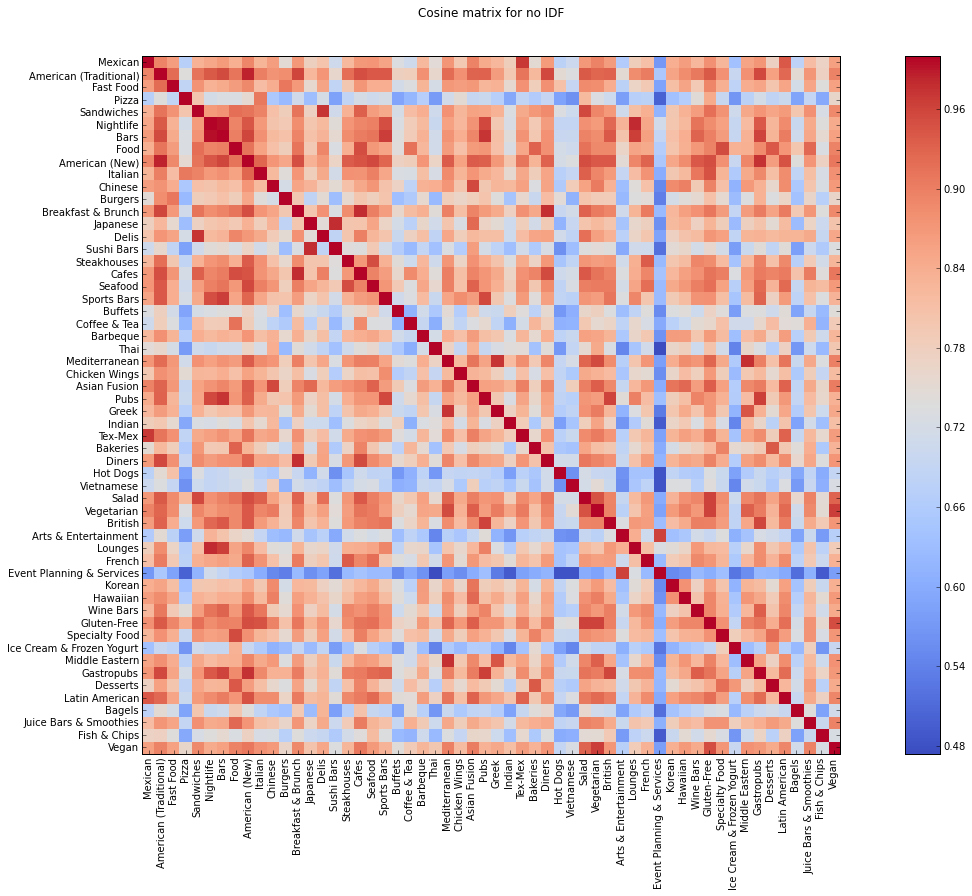

In [255]:
showSimilarityMatrix(tf_cosine_matrix, 'Cosine matrix for no IDF', 'tf_cosine_matrix.png')

The result we've got is not so good, many categories appear to be quite similar based on the current similarity matrix. Further we're going to make steps to improve the result.

## Visualization for TF-IDF model ##
The first step to improve the feature vector for cousines is to use IDF (inverse document frequency).

In [87]:
tf_idf_matrix = buildTF_IDF(reviewsByCategories)
tf_idf_cosine_matrix = cosine_matrix(tf_idf_matrix)
print tf_idf_cosine_matrix

[[ 1.          0.89339224  0.85980427 ...,  0.80722953  0.76595454
   0.85405802]
 [ 0.89339224  1.          0.91979234 ...,  0.86716728  0.77264047
   0.89314275]
 [ 0.85980427  0.91979234  1.         ...,  0.84505284  0.73467881
   0.8533529 ]
 ..., 
 [ 0.80722953  0.86716728  0.84505284 ...,  1.          0.69369647
   0.88899819]
 [ 0.76595454  0.77264047  0.73467881 ...,  0.69369647  1.          0.72013782]
 [ 0.85405802  0.89314275  0.8533529  ...,  0.88899819  0.72013782  1.        ]]


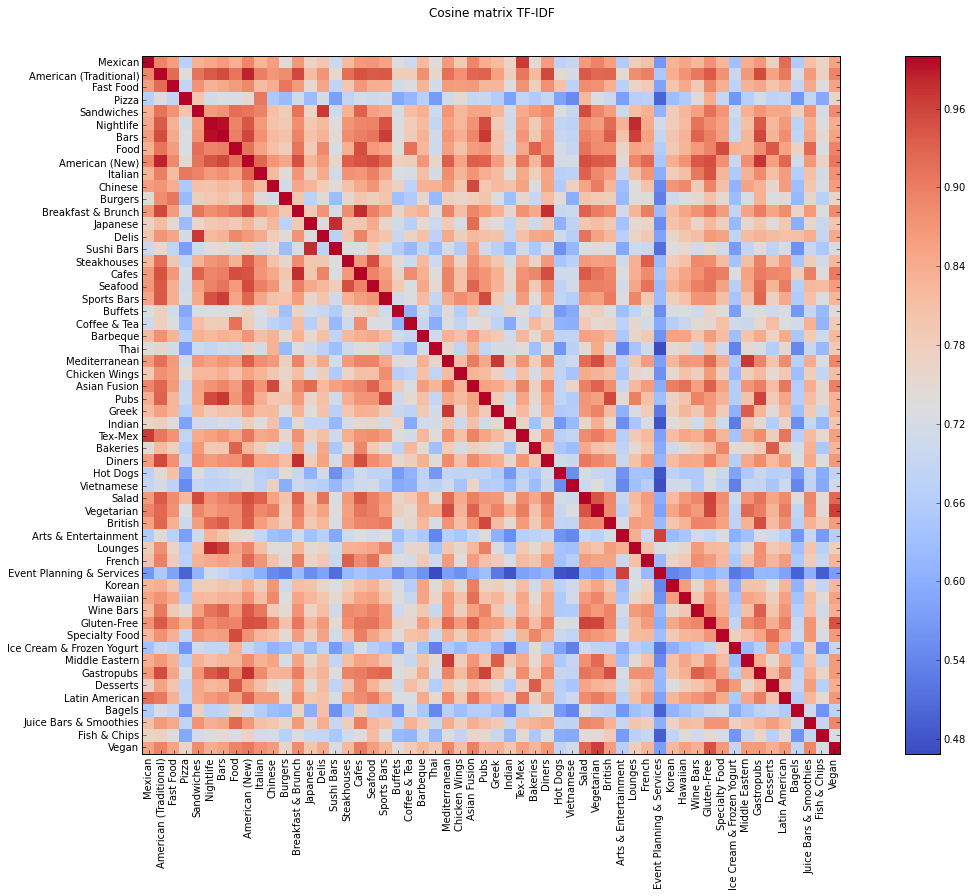

In [257]:
showSimilarityMatrix(tf_idf_cosine_matrix, 'Cosine matrix TF-IDF', 'tf_idf_cosine_matrix.png')

## Tuned TF-IDF model ##

Based on previous similarity matrices we can see that many categories has quite high similarity measure. The reason is because built-in stop words from TfidfVectorizer is quite general and work well only for general texts but we bump with many general words specific for restaurant reviews. Examples could be 'good', 'just' or 'food'. From other side we need bear in mind that reviews could have words with misspellings but the IDF part will reward such words like this is a unique and very specific word that characterizes a text.

TfidfVectorizer from sklearn has two parameters for these purposes:
* max_df : When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts.
* min_df : When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts.

In [32]:
tuned_tf_idf_matrix = buildTF_IDF(reviewsByCategories, use_idf=True, max_df=0.8, min_df=2)
tuned_tf_idf_cosine_matrix = cosine_matrix(tuned_tf_idf_matrix)
print tuned_tf_idf_cosine_matrix

[[ 1.          0.07551263  0.11090874 ...,  0.02254244  0.0259091
   0.02246403]
 [ 0.07551263  1.          0.25389918 ...,  0.05613452  0.04598283
   0.03319007]
 [ 0.11090874  0.25389918  1.         ...,  0.03486206  0.09302258
   0.02966955]
 ..., 
 [ 0.02254244  0.05613452  0.03486206 ...,  1.          0.0090851
   0.10549814]
 [ 0.0259091   0.04598283  0.09302258 ...,  0.0090851   1.          0.00894806]
 [ 0.02246403  0.03319007  0.02966955 ...,  0.10549814  0.00894806  1.        ]]


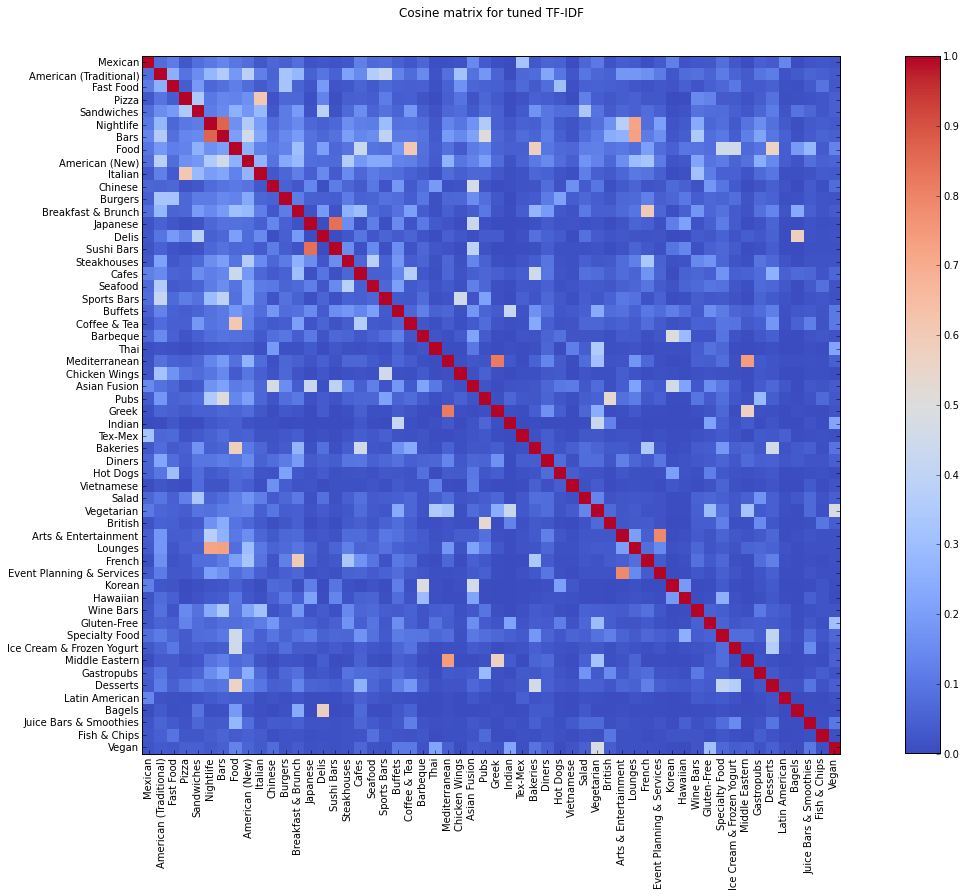

In [263]:
showSimilarityMatrix(tuned_tf_idf_cosine_matrix, 'Cosine matrix for tuned TF-IDF', 'tuned_tf_idf_cosine_matrix.png')

The similarity matrix looks now significant better, we can observe long distance between quite different cuisines while categories that actually relate to a same restaurant type have still high similarity, for example 'Pizza' and 'Italian' have quite high similarity, or another example is 'Japanese' and 'Sushi bars' are extremely similar (the distance is about 0.9).

To confirm this statement, we can make the next step and perform clustering. I chose the hierarchy clustering and clustering as dendrogram since it provides the easiest to read view and emphasize what cuisines are quite similar and how close are a whole groups of cuisines.

In [24]:
import pylab

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

def visualize_hierarchy_clusterization(cosine_matrix, filename, linkage_method='average'):
    linkage_matrix = linkage(cosine_matrix, linkage_method)
    fig = pylab.figure(figsize=(23.5, 12.5))

    dendrogram(linkage_matrix, labels=cuisines, leaf_rotation=90., leaf_font_size=8.)

    fig.savefig(filename)
    plt.show()

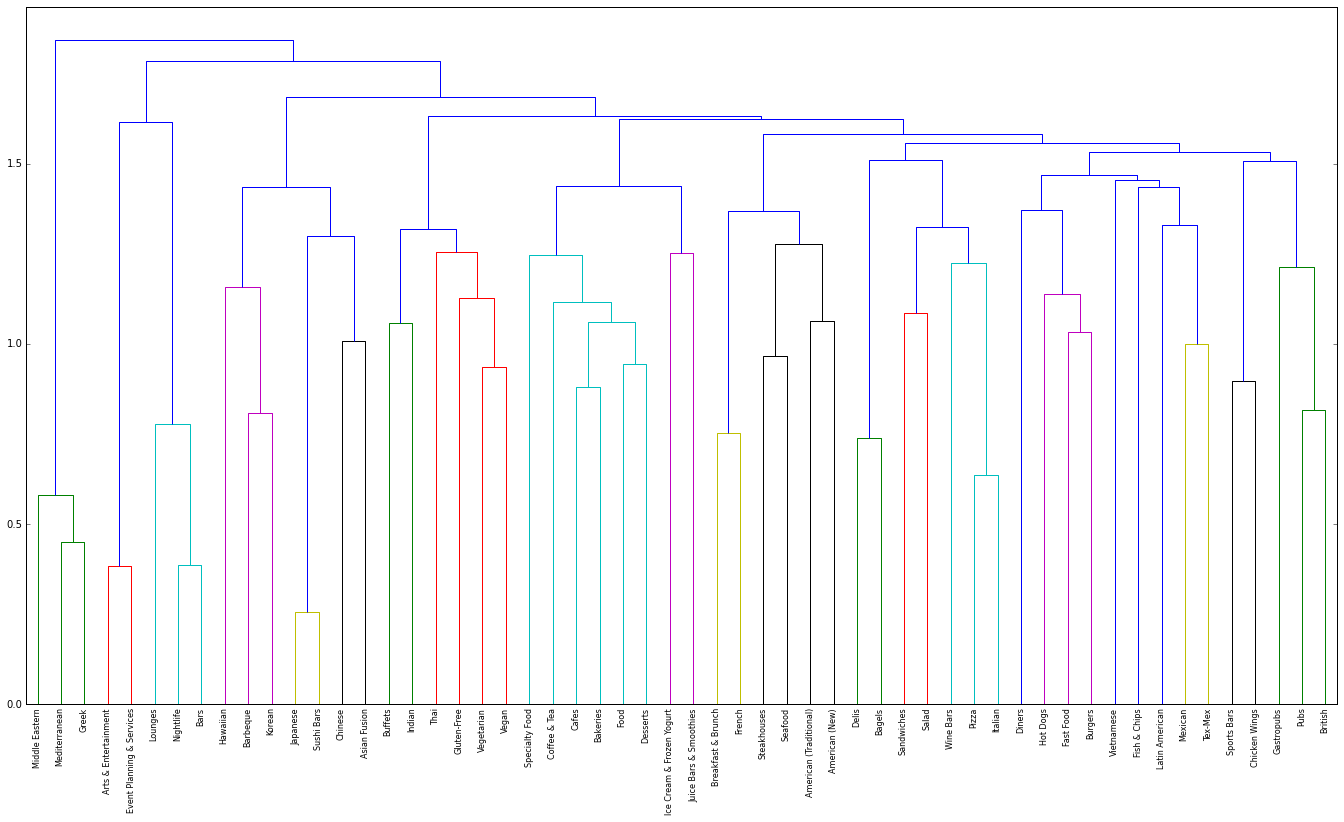

In [315]:
visualize_hierarchy_clusterization(tuned_tf_idf_cosine_matrix, 'tuned_tf_idf_dendrogram.png')

We can see the result here is quite sensible. Let's follow when different cuisines are combined together during clustering. The first categories that has been combined were Japanese and Sushi Bars and indeed they offer almost identical dishes. The next candidate to combine were Nighlife and Bars, also very similiar type of places. The same think with Art & Entertainment and Event Planning. The next sensible combination is a combination of Mediaterian and Greek. From perspective of not so good combination can be Thai and a group of (Gluten-Free, Vegetarian, Vegan).

## Adding pre-processing step before build TF-IDF model ##

The idea of the next improvement is to add a pre-processing step in scope of which we'll delete punctuation and perform stemming. That should reduce the dimension of feature space and increase accuracy of comparison.


We are going to use nltk library (in particularly stemming package http://www.nltk.org/api/nltk.stem.html), but before we should download and install packages. This is an one-time oeration and can be done from python console.

In [313]:
import nltk
nltk.download()

showing info http://www.nltk.org/nltk_data/


True

ntlk provides a series of Stemmers:
* *The Porter Stemming Algorithm* 
* *The Lancaster Stemming Algorithm* 
* *The WordNet Lemmatizer* 

I'm going to use Lancaster because it is much newer, published in 1990, and can be more aggressive than the Porter stemming algorithm. Attempt to use WordNet Lemmatizer looks also as intresting option because it uses the WordNet Database to lookup lemmas. Lemmas differ from stems in that a lemma is a canonical form of the word, while a stem may not be a real word.

The preprocessing function is presented below. It will be used as a template for different stemmers. 

In [9]:
import string

remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def processReviews(category):
    businessesByCategory = businessDF[contains(businessDF.categories, lit(category))]
    selectedReviewsDF = reviewsDF.join(businessesByCategory,\
                                       businessesByCategory.business_id == reviewsDF.business_id)      
    return (selectedReviewsDF.select("text")
            .map(lambda x: x.text)
            .map(lambda x: x.translate(remove_punctuation_map))
            .reduce(lambda x,y : x + y))
    
reviewsWithoutPunctuationRDD = [processReviews(c) for c in cuisines]

In [10]:
import nltk

'''remove punctuation, lowercase, stem'''
def tokenize_with_stemmer(stemmer, text):
    tokens = nltk.word_tokenize(text)
    return [stemmer.stem(item) for item in tokens]

In [50]:
from nltk.stem.lancaster import LancasterStemmer

lancaster_stemmer = LancasterStemmer()
lancaster_tf_idf_matrix = buildTF_IDF(reviewsWithoutPunctuationRDD, use_idf=True, max_df=0.8, min_df=2,
                                        tokenizer=(lambda x: tokenize_with_stemmer(lancaster_stemmer, x)))
lancaster_tf_idf_cosine_matrix = cosine_matrix(lancaster_tf_idf_matrix)
print lancaster_tf_idf_cosine_matrix

[[ 1.          0.08513418  0.10832436 ...,  0.02241413  0.02751887
   0.02013912]
 [ 0.08513418  1.          0.26492506 ...,  0.05719009  0.04493049
   0.03435753]
 [ 0.10832436  0.26492506  1.         ...,  0.02339629  0.09415454
   0.02938565]
 ..., 
 [ 0.02241413  0.05719009  0.02339629 ...,  1.          0.00641512
   0.1068233 ]
 [ 0.02751887  0.04493049  0.09415454 ...,  0.00641512  1.          0.01260946]
 [ 0.02013912  0.03435753  0.02938565 ...,  0.1068233   0.01260946  1.        ]]


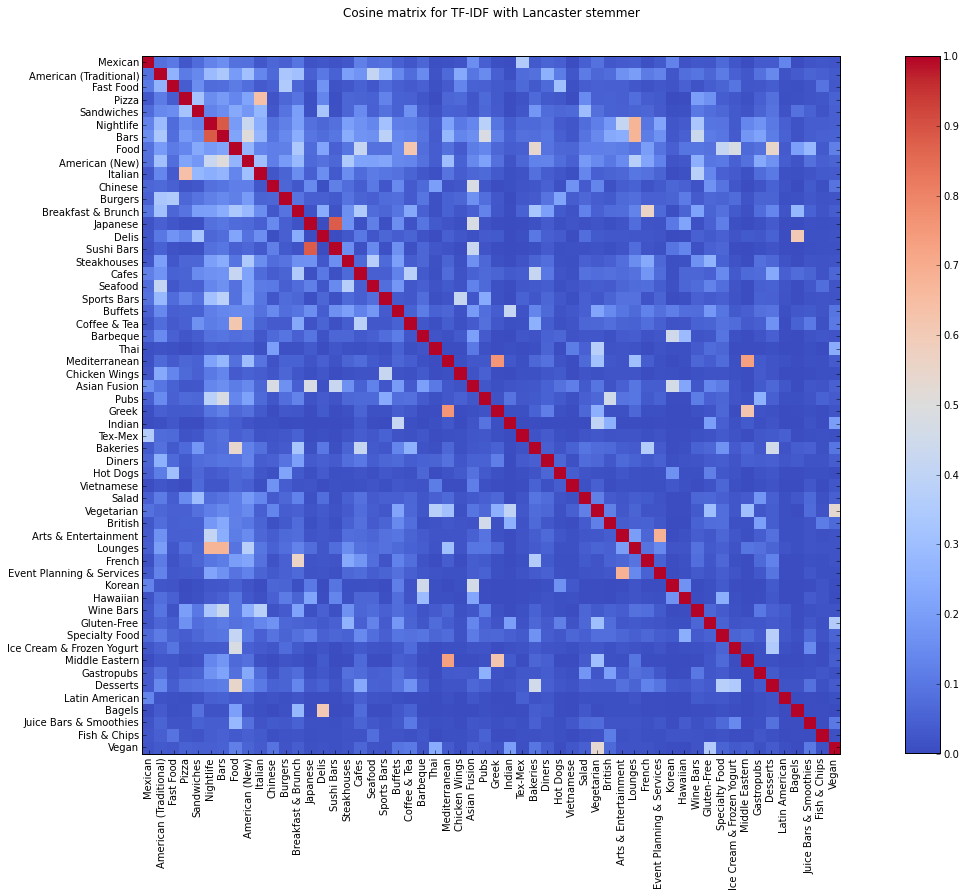

In [64]:
showSimilarityMatrix(lancaster_tf_idf_cosine_matrix, 'Cosine matrix for TF-IDF with Lancaster stemmer', 
                     'lancaster_tf_idf_cosine_matrix.png')

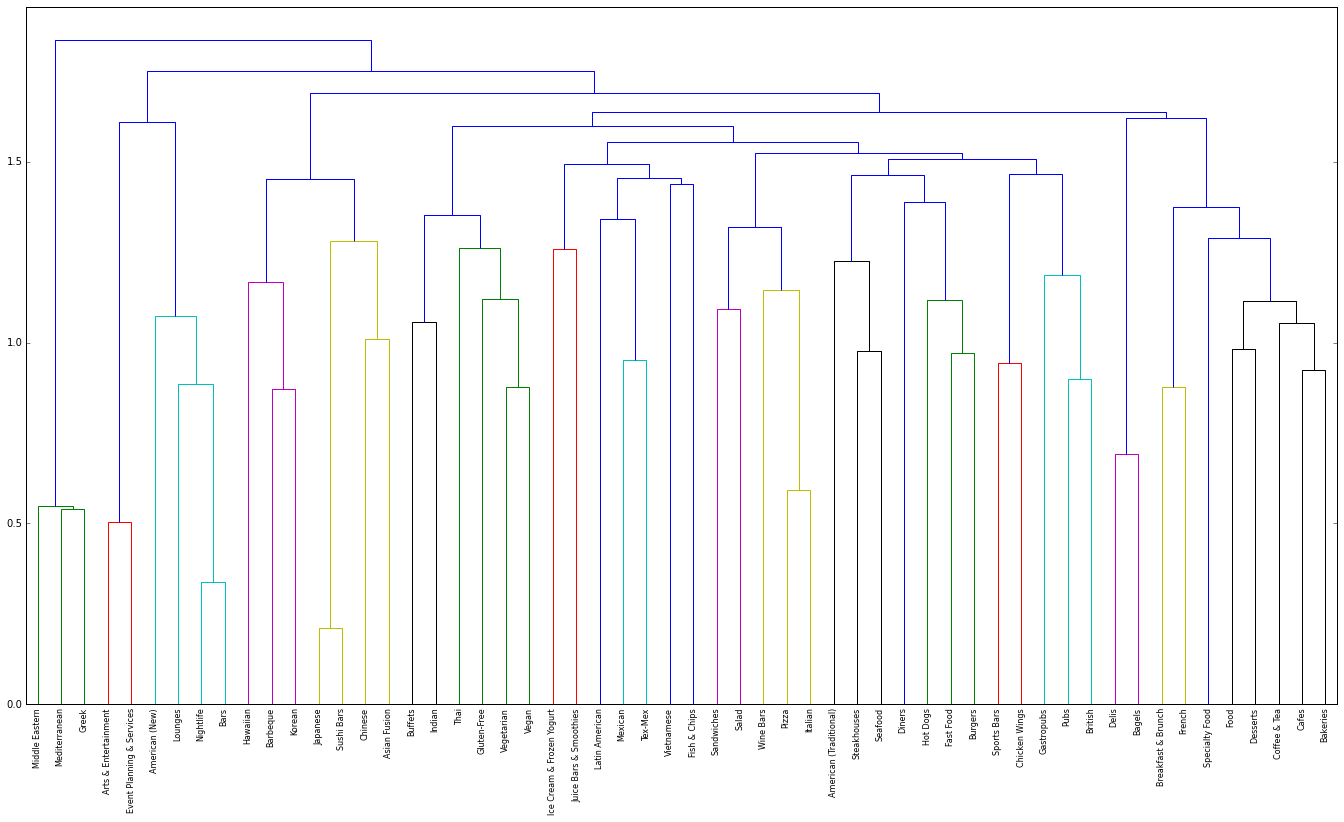

In [65]:
visualize_hierarchy_clusterization(lancaster_tf_idf_cosine_matrix, 'lancaster_tf_idf_cosine_hierachy.png')

In [63]:
from nltk.stem.porter import PorterStemmer

porterStemmer = PorterStemmer()
porter_tf_idf_matrix = buildTF_IDF(reviewsWithoutPunctuationRDD, max_df=0.8, min_df=2,
                                        tokenizer=(lambda x: tokenize_with_stemmer(porterStemmer, x)))
porter_tf_idf_cosine_matrix = cosine_matrix(porter_tf_idf_matrix)
print porter_tf_idf_cosine_matrix

[[ 1.          0.07980574  0.10909734 ...,  0.02422357  0.0227194
   0.0210174 ]
 [ 0.07980574  1.          0.25272477 ...,  0.05916129  0.04696799
   0.03299639]
 [ 0.10909734  0.25272477  1.         ...,  0.03520485  0.09635818
   0.03143788]
 ..., 
 [ 0.02422357  0.05916129  0.03520485 ...,  1.          0.00886478
   0.10337411]
 [ 0.0227194   0.04696799  0.09635818 ...,  0.00886478  1.          0.01297029]
 [ 0.0210174   0.03299639  0.03143788 ...,  0.10337411  0.01297029  1.        ]]


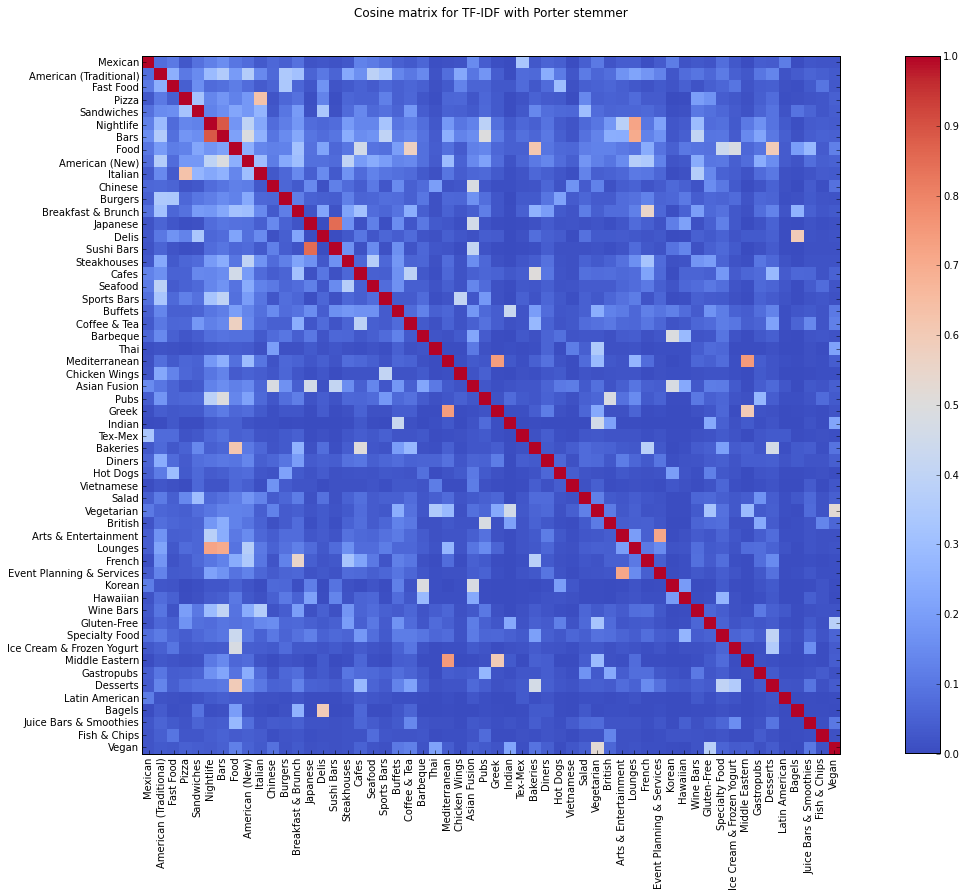

In [66]:
showSimilarityMatrix(porter_tf_idf_cosine_matrix, 'Cosine matrix for TF-IDF with Porter stemmer', 
                     'porter_tf_idf_cosine_matrix.png')

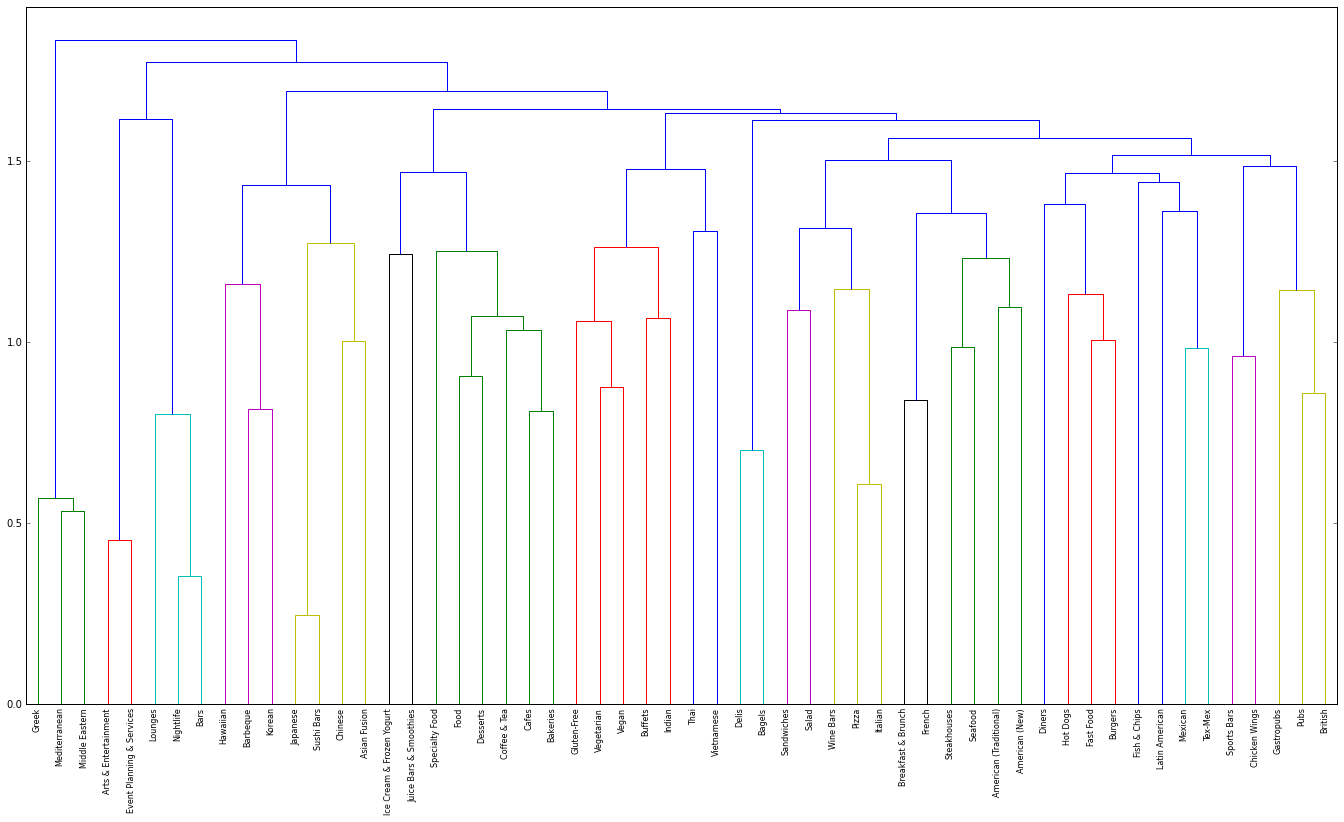

In [67]:
visualize_hierarchy_clusterization(porter_tf_idf_cosine_matrix, 'porter_tf_idf_cosine_hierachy.png')

In [72]:
import nltk

'''remove punctuation, lowercase, stem'''
def tokenize_with_lemmatizer(emmatizer, text):
    tokens = nltk.word_tokenize(text)
    return [emmatizer.lemmatize(item) for item in tokens]

In [73]:
from nltk.stem.wordnet import WordNetLemmatizer

wordNetLemmatizer = WordNetLemmatizer()
wordNet_tf_idf_matrix = buildTF_IDF(reviewsWithoutPunctuationRDD, max_df=0.8, min_df=2,
                                        tokenizer=(lambda x: tokenize_with_lemmatizer(wordNetLemmatizer, x)))
wordNet_tf_idf_cosine_matrix = cosine_matrix(wordNet_tf_idf_matrix)
print wordNet_tf_idf_cosine_matrix

[[ 1.          0.08148087  0.10456627 ...,  0.02495287  0.02500562
   0.02399638]
 [ 0.08148087  1.          0.24265099 ...,  0.06026135  0.05037813
   0.03550103]
 [ 0.10456627  0.24265099  1.         ...,  0.03719325  0.08534482
   0.03315107]
 ..., 
 [ 0.02495287  0.06026135  0.03719325 ...,  1.          0.00934224
   0.11127105]
 [ 0.02500562  0.05037813  0.08534482 ...,  0.00934224  1.          0.01350244]
 [ 0.02399638  0.03550103  0.03315107 ...,  0.11127105  0.01350244  1.        ]]


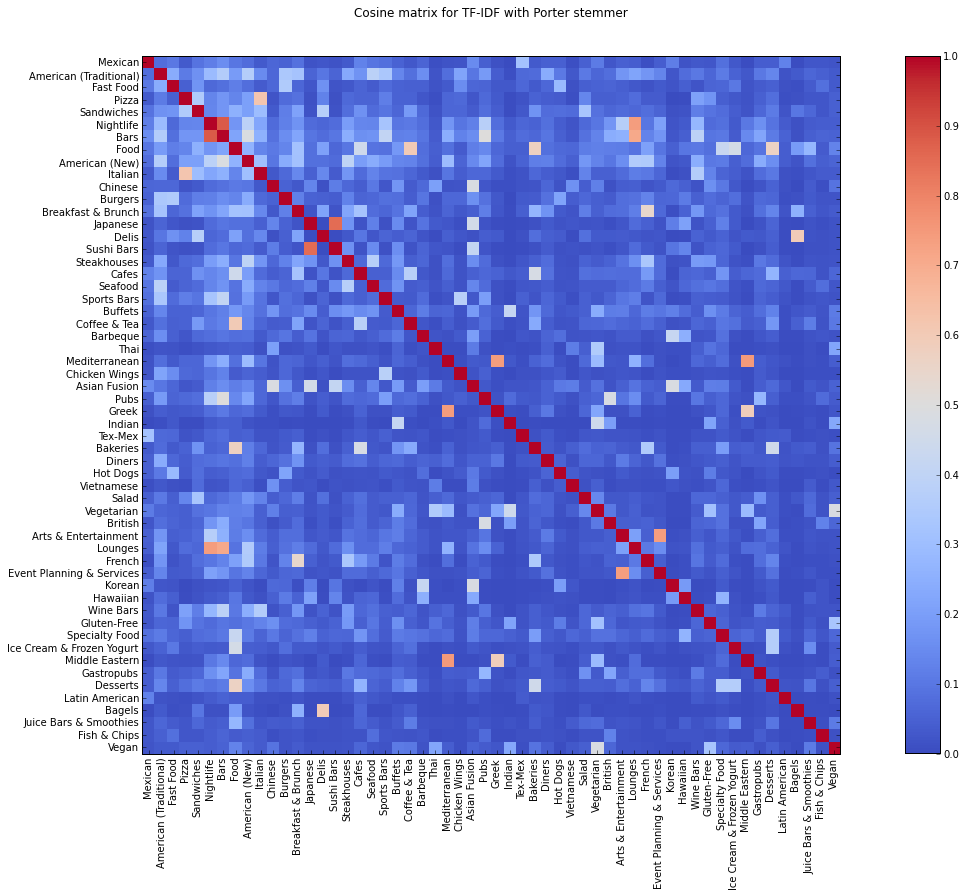

In [74]:
showSimilarityMatrix(wordNet_tf_idf_cosine_matrix, 'Cosine matrix for TF-IDF with Porter stemmer', 
                     'wordNet_tf_idf_cosine_matrix.png')

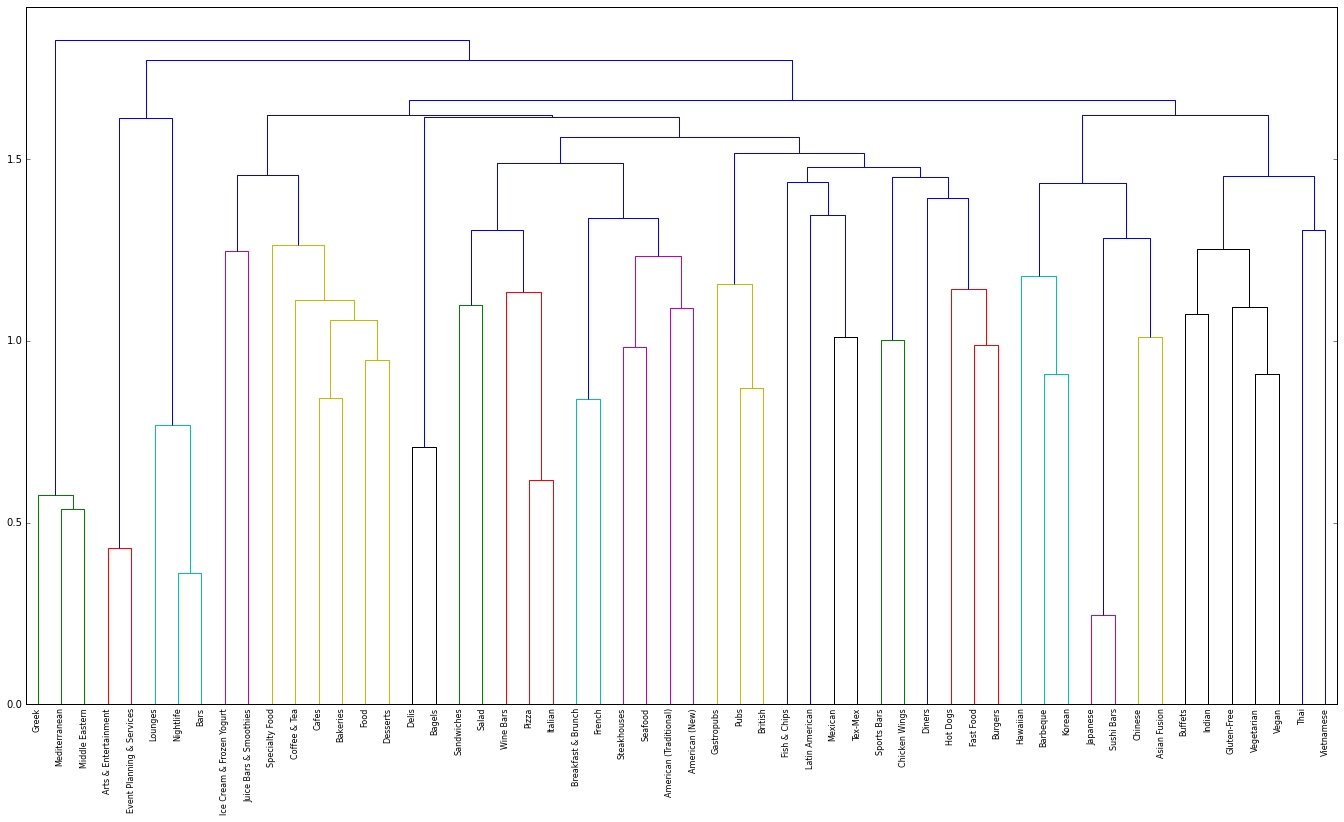

In [75]:
visualize_hierarchy_clusterization(wordNet_tf_idf_cosine_matrix, 'wordNet_tf_idf_cosine_hierachy.png')

## TF-IDF model without filtering and with Lancaster stemming ##
Now let's analyse what would be the result if we disable the filtering of high frequent term but still will apply Lancaster stemming algorithm.

In [78]:
lancaster2_tf_idf_matrix = buildTF_IDF(reviewsWithoutPunctuationRDD, use_idf=True, min_df=2,
                                        tokenizer=(lambda x: tokenize_with_stemmer(lancaster_stemmer, x)))
lancaster2_tf_idf_cosine_matrix = cosine_matrix(lancaster2_tf_idf_matrix)
print lancaster2_tf_idf_cosine_matrix

[[ 1.          0.92821414  0.90358543 ...,  0.86897245  0.85458866
   0.90872237]
 [ 0.92821414  1.          0.9445329  ...,  0.90488745  0.86240121
   0.93280311]
 [ 0.90358543  0.9445329   1.         ...,  0.90148534  0.83963027
   0.91082621]
 ..., 
 [ 0.86897245  0.90488745  0.90148534 ...,  1.          0.80023345
   0.93044509]
 [ 0.85458866  0.86240121  0.83963027 ...,  0.80023345  1.          0.82831546]
 [ 0.90872237  0.93280311  0.91082621 ...,  0.93044509  0.82831546  1.        ]]


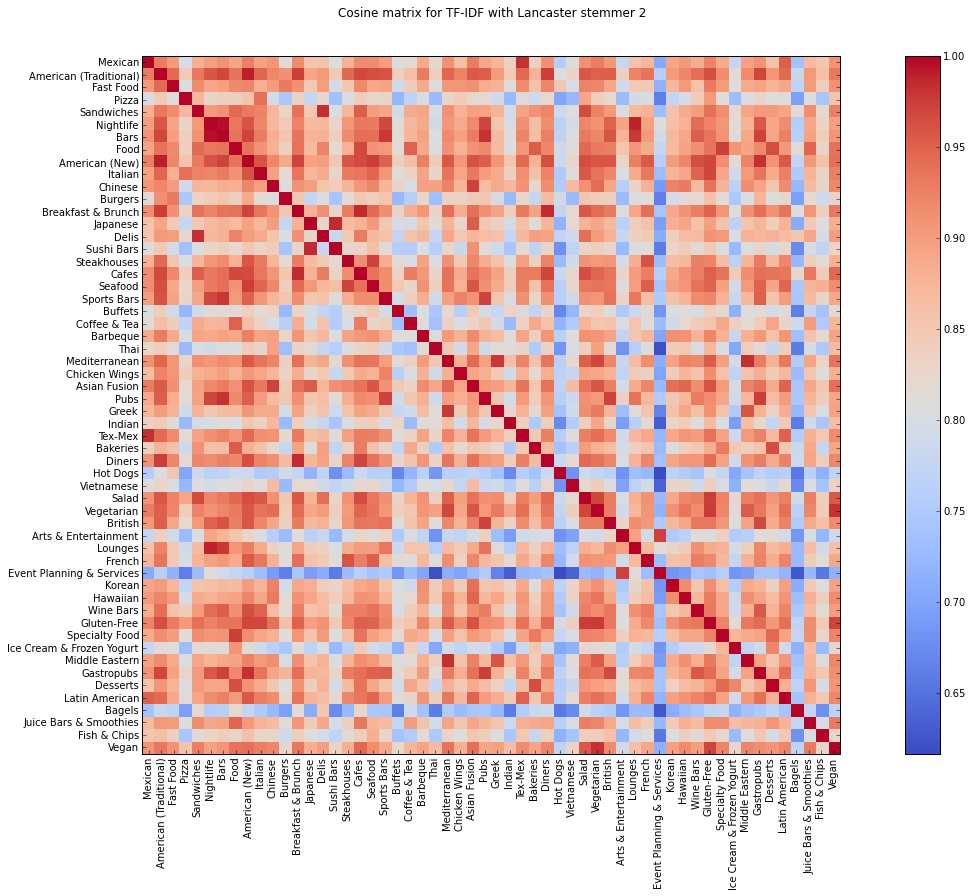

In [80]:
showSimilarityMatrix(lancaster2_tf_idf_cosine_matrix, 'Cosine matrix for TF-IDF with Lancaster stemmer 2', 
                     'lancaster2_tf_idf_cosine_matrix.png')

We can see that Lancaster stemming algorithm is too agressive and it make all text very similiar and without filtering it is higher. 

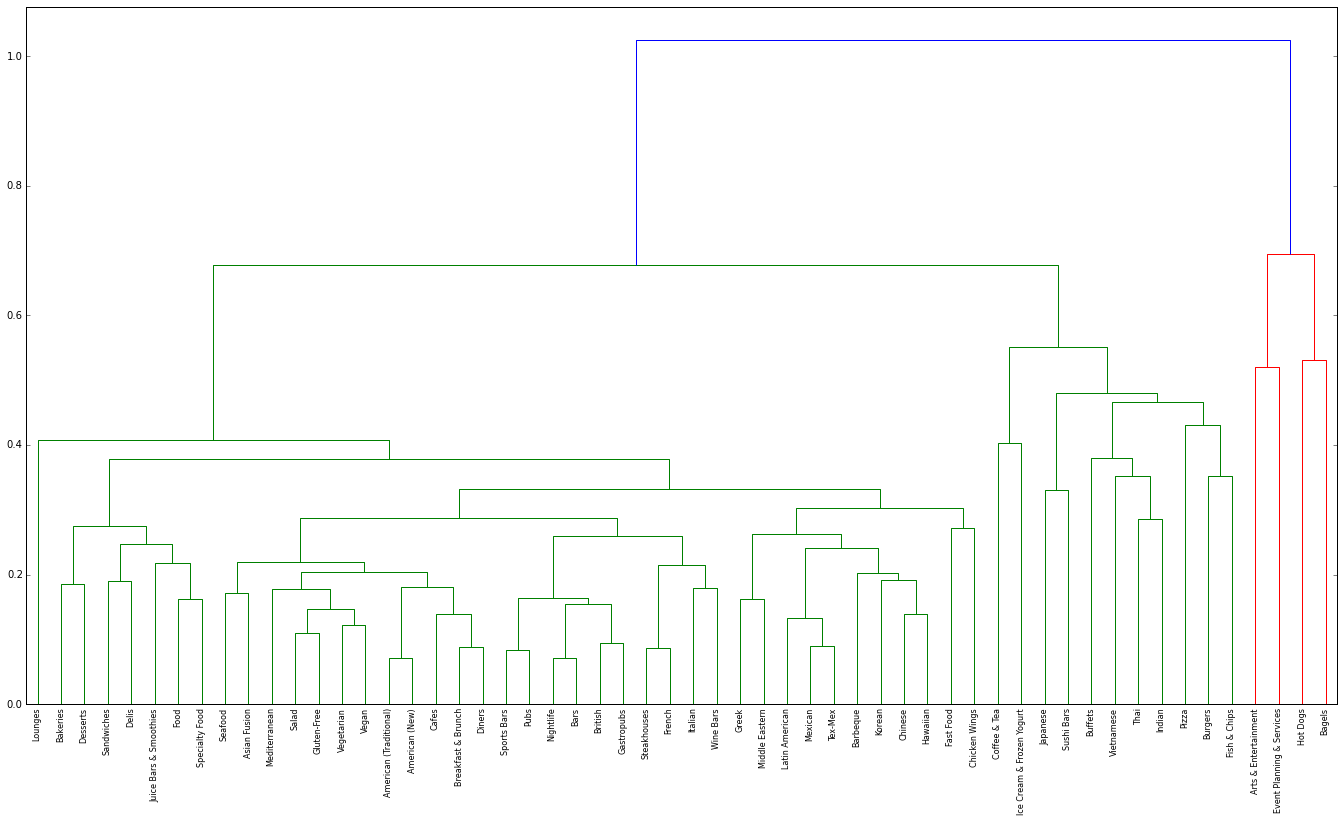

In [81]:
visualize_hierarchy_clusterization(lancaster2_tf_idf_cosine_matrix, 'lancaster2_tf_idf_cosine_hierachy.png')

The result of hierarchy clustering seems to be not so sensable, basically the algorithm combines almost all categories into one since they are very close to each other.

## Measuring clustering's quality ##
We can check a quality of built clusters. Since there are no known ground truth labels, so the evaluation must be performed using the model itself. *Silhouette Index* is one of the most popular ways of measuring a particular clustering's quality. It measures how similar each pattern is to the patterns in it's own cluster as compared to patterns in other clusters. Silhouette score close to one means that the datum is appropriately clustered. If the score is close to negative one, then by the same logic we see that some items would be more appropriate if it was clustered in its neighboring cluster. A score near zero means that the datum is on the border of two natural clusters.


We are going to use the implementation from scikit-learn python library for Silhouette score calculation (http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient). For clustering we're going to use an enhanced version of K-means algorithm named Mini Batch K-Means (http://scikit-learn.org/stable/modules/clustering.html#mini-batch-k-means). Silhouette score will be depicted as a plot score/number of clusters. 

In [55]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def calculate_silhouette_score(cosine_matrix, n_clusters):
    model = MiniBatchKMeans(n_clusters=n_clusters, random_state=1).fit(cosine_matrix)
    return metrics.silhouette_score(lancaster_tf_idf_cosine_matrix, model.labels_, metric='euclidean')  

In [91]:
min_n_cluster = 2
max_n_cluster = 40

tf_silhouette_scores=[calculate_silhouette_score(tf_cosine_matrix, i) \
                             for i in range(min_n_cluster, max_n_cluster)]

tf_idf_silhouette_scores=[calculate_silhouette_score(tf_idf_cosine_matrix, i) \
                             for i in range(min_n_cluster, max_n_cluster)]

tuned_silhouette_scores=[calculate_silhouette_score(tuned_tf_idf_cosine_matrix, i) \
                             for i in range(min_n_cluster, max_n_cluster)]

lancaster_silhouette_scores=[calculate_silhouette_score(lancaster_tf_idf_cosine_matrix, i)\
                             for i in range(min_n_cluster, max_n_cluster)]

porter_silhouette_scores=[calculate_silhouette_score(porter_tf_idf_cosine_matrix, i)\
                             for i in range(min_n_cluster, max_n_cluster)]

wordNet_silhouette_scores=[calculate_silhouette_score(wordNet_tf_idf_cosine_matrix, i)\
                             for i in range(min_n_cluster, max_n_cluster)]


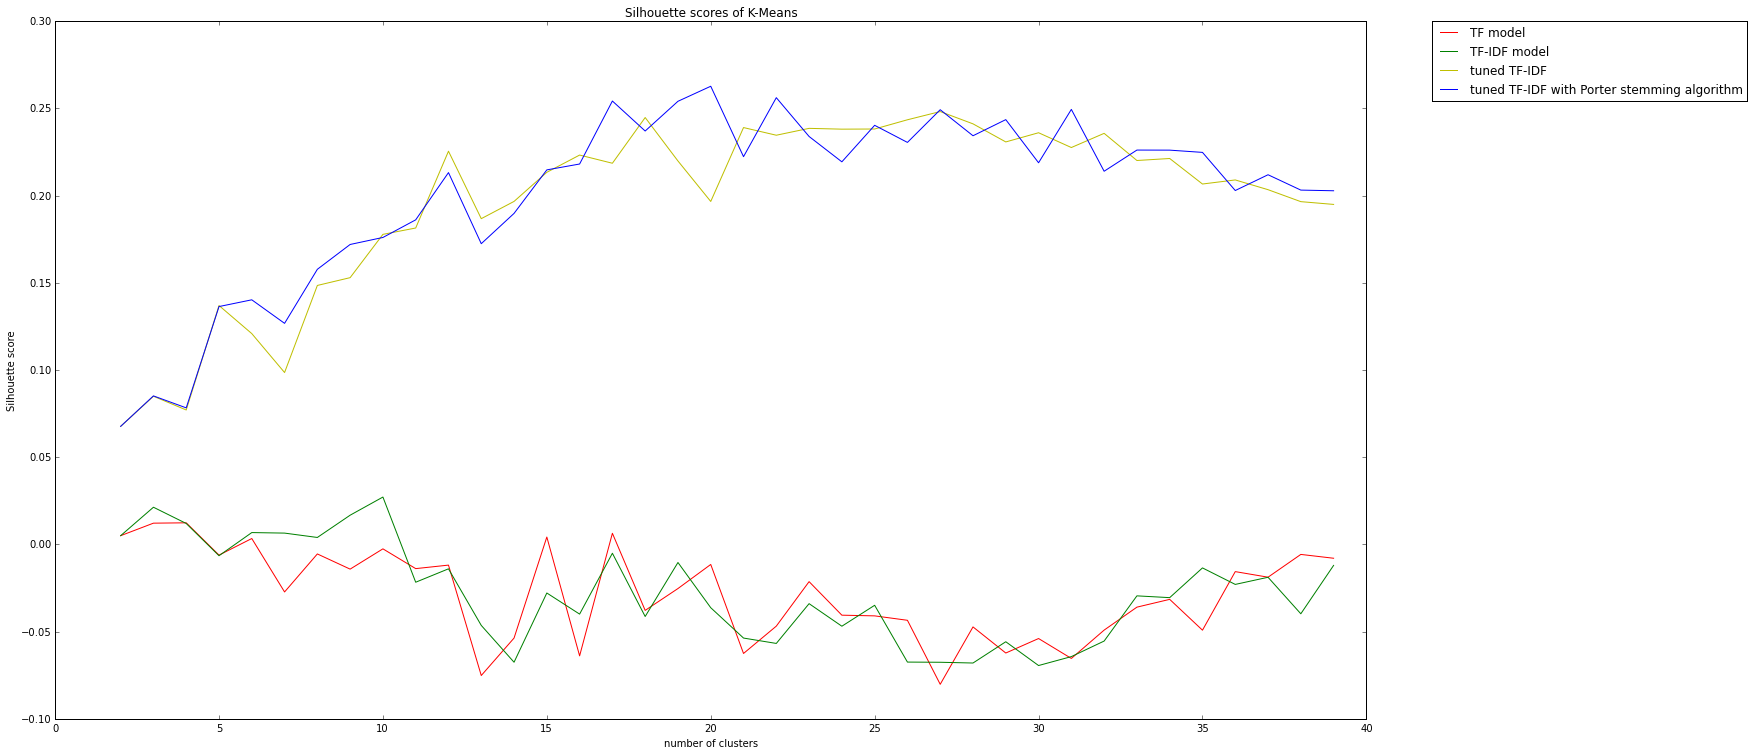

In [92]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(min_n_cluster, max_n_cluster)

plt.plot(x, tf_silhouette_scores, 'r', label='TF model')
plt.plot(x, tf_idf_silhouette_scores, 'g', label='TF-IDF model')
plt.plot(x, tuned_silhouette_scores, 'y', label='tuned TF-IDF')
plt.plot(x, porter_silhouette_scores, 'b', label='tuned TF-IDF with Porter stemming algorithm')

plt.xlabel('number of clusters')
plt.ylabel('Silhouette score')

plt.title('Silhouette scores of K-Means')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.gcf().set_size_inches(23.5, 12.5)
plt.show()

From the graph above we can see that TF and TF-IDF model are significant worse than tuned TF-IDF and TF-IDF after stemming. The maximum value of Silhouette Index reaches for option TF-IDF with stemming and for 19 clusters. Let’s construct these clusters: 

In [103]:
model = MiniBatchKMeans(n_clusters=18, random_state=1).fit(porter_tf_idf_cosine_matrix)

clusters = dict()
for i, label in enumerate(model.labels_):
    if label not in clusters:
        clusters[label] = [cuisines[i]]
    else:
        clusters[label].append(cuisines[i])
    
for i in clusters:
    print "cluster {}: {}".format(i + 1, ', '.join(clusters[i]))


cluster 1: Gastropubs
cluster 2: American (Traditional), American (New), Steakhouses, Seafood
cluster 3: Specialty Food, Ice Cream & Frozen Yogurt, Desserts, Juice Bars & Smoothies
cluster 4: Nightlife, Bars, Lounges
cluster 5: Food, Breakfast & Brunch, Cafes, Coffee & Tea, Bakeries, French
cluster 6: Japanese, Sushi Bars, Asian Fusion
cluster 7: Buffets, Indian, Vegetarian, Gluten-Free, Vegan
cluster 8: Sandwiches, Salad
cluster 9: Fast Food, Burgers, Diners, Hot Dogs
cluster 10: Arts & Entertainment, Event Planning & Services
cluster 11: Chinese, Thai
cluster 12: Mediterranean, Greek, Middle Eastern
cluster 13: Delis, Bagels
cluster 14: Pizza, Italian, Wine Bars
cluster 15: Mexican, Tex-Mex, Vietnamese, Latin American, Fish & Chips
cluster 16: Pubs, British
cluster 17: Sports Bars, Chicken Wings
cluster 18: Barbeque, Korean, Hawaiian
